## Diffusion-Limited Aggregation

10.17-19:09:33


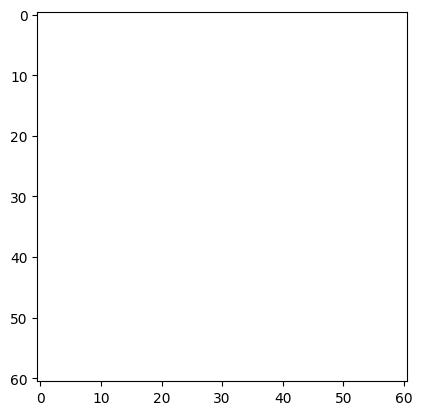

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from IPython import display
import time

rng = np.random.default_rng()

# Length of one side of the grid
S = 61

# World grid
world = []

# Number of active walkers to maintain
W = 30

# Collection of active walkers
walkers = []

# Collection of cells currently in the aggregate
aggregate = []

# Chance for a walker to go up+left, up, up+right, left, right, down+left, down, down+right, respectively
chances = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
# chances = [.25, 0, .25, 0, 0, .25, 0, .25]
summed_chances = [np.sum(chances[0:1:1]), np.sum(chances[0:2:1]),
                  np.sum(chances[0:3:1]), np.sum(chances[0:4:1]),
                  np.sum(chances[0:5:1]), np.sum(chances[0:6:1]),
                  np.sum(chances[0:7:1]), np.sum(chances[0:8:1])]

# displays the current state of world cells
def display_world():
    plt.imshow(world, cmap=plt.get_cmap(cm.Greys))
    display.display(plt.gcf())
    display.clear_output(wait=True)

def get_edge_spot():
    return(rng.integers(S),rng.integers(S))
    # edge_offset = rng.integers(1)
    # roll = rng.random()
    # if roll < 0.25:
    #     return (edge_offset,rng.integers(S))
    # if roll < 0.5:
    #     return (S-1-edge_offset,rng.integers(S))
    # if roll < 0.75:
    #     return (rng.integers(S),edge_offset)
    # else:
    #     return (rng.integers(S),S-1-edge_offset)

def spawn_new_walker():
    spawn = get_edge_spot()
    while world[spawn[0]][spawn[1]] != 0 or is_aggregate_adjacent(spawn):
        spawn = get_edge_spot()
    world[spawn[0]][spawn[1]] = 1
    walkers.append(spawn)

# def is_valid_step(target):
#     if target[0] < 0: return False
#     if target[0] > S-1: return False
#     if target[1] < 0: return False
#     if target[1] > S-1: return False
#     if world[target[0]][target[1]] == 1: return False
#     return True

def is_aggregate_adjacent(cell):
    i = cell[0]
    j = cell[1]
    if world[(i+1)%S][j] == 2:
        return True
    if world[(i+1)%S][(j+1)%S] == 2:
        return True
    if world[(i+1)%S][(j-1)%S] == 2:
        return True
    if world[i][(j+1)%S] == 2:
        return True
    if world[i][(j-1)%S] == 2:
        return True
    if world[(i-1)%S][j] == 2:
        return True
    if world[(i-1)%S][(j+1)%S] == 2:
        return True
    if world[(i-1)%S][(j-1)%S] == 2:
        return True
    # if we want to also check diagonals that would go here

def update_walker(walker):
    moved = False
    while not moved:
        roll = rng.random()
        if roll < summed_chances[0]: # move up/left
            target = ((walker[0]+1)%S, (walker[1]-1)%S)
        elif roll < summed_chances[1]: # move up
            target = ((walker[0]+1)%S, walker[1])
        elif roll < summed_chances[2]: # move up/right
            target = ((walker[0]+1)%S, (walker[1]+1)%S)
        elif roll < summed_chances[3]: # move left
            target = (walker[0],(walker[1]-1)%S)
        elif roll < summed_chances[4]: # move right
            target = (walker[0],(walker[1]+1)%S)
        elif roll < summed_chances[5]: # move down/left
            target = ((walker[0]-1)%S, (walker[1]-1)%S)
        elif roll < summed_chances[6]: # move down
            target = ((walker[0]-1)%S, walker[1])
        elif roll < summed_chances[7]: # move down/right
            target = ((walker[0]-1)%S, (walker[1]+1)%S)
        
        if world[target[0]][target[1]] == 0:
            if is_aggregate_adjacent(target):
                world[walker[0]][walker[1]] = 0
                walkers.remove(walker)
                world[target[0]][target[1]] = 2
                aggregate.append(target)
            else:
                world[walker[0]][walker[1]] = 0
                world[target[0]][target[1]] = 1
                walkers[walkers.index(walker)] = target
            moved = True

# set up initial world
world = np.zeros((S,S))
world[S//2][S//2] = 2
aggregate.append((S//2,S//2))

# set up initial walkers
for n in range(W):
    spawn_new_walker()

img = [] # frame images
running = True
fig = plt.figure()
while len(aggregate) < 50:
    # display_world()
    for walker in walkers:
        update_walker(walker)
    while len(walkers) < W:
        spawn_new_walker()
    img.append([plt.imshow(world, cmap=plt.get_cmap(cm.Greys))])

# print("sim done")
# frames = [] # for storing the generated images
# for i in range(len(img)):
#     frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

ani = animation.ArtistAnimation(fig=fig, artists=img, interval=100)
timestamp = time.strftime("%m-%d-%H-%M-%S", time.localtime())
print(timestamp)
ani.save(f'{timestamp}-movie.gif', writer="pillow")
# plt.show()
# display_world()